In [1]:
import pandas as pd
import warnings
import numpy as np
import tensorflow as tf
import os
import sys
child_dir = os.path.abspath('dfl')
sys.path.append(child_dir)
from dfl.whittle import newWhittleIndex
from dfl.trajectory import getSimulatedTrajectories
from dfl.policy import getProbs
from dfl.ope import eval_policy
import matplotlib.pyplot as plt
import datetime
import random
import os
import sys
child_dir = os.path.abspath('dfl')
sys.path.append(child_dir)

/Users/gaurijain/Desktop/projects/lib/python3.9/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
def create_transitions_n_history(n_history,transitions):
    n = len(transitions)
    transitions_full = np.zeros((n, 2**n_history, 2, 2**n_history))
    for i in range(n):
        for j in range(2**n_history):
            bin_val = bin(j)[2:]
            curr_state = (n_history-len(bin_val))*'0' + bin_val
            next_state_0 = int(curr_state[1:] + '0', 2)
            next_state_1 = int(curr_state[1:] + '1', 2)

            # action = 0
            trans = transitions[i,int(bin(j)[-1]), 0]
            transitions_full[i, j, 0, next_state_0] = 1 - trans
            transitions_full[i, j, 0, next_state_1] = trans

            # action = 1
            trans = transitions[i,int(bin(j)[-1]), 1]
            transitions_full[i, j, 1, next_state_0] = 1 - trans
            transitions_full[i, j, 1, next_state_1] = trans

    return transitions_full

In [3]:
def get_simpleish_transitions(n_history,n_benefs):
    transitions_full = np.zeros((n_benefs, 2 ** n_history, 2, 2 ** n_history))
    transitions = np.zeros((2,2))
    for i in range(n_benefs):
        transitions[0, 0] = np.random.uniform(0, 0.3)
        transitions[0, 1] = np.random.uniform(.4, .7)
        transitions[1, 0] = np.random.uniform(0.3, .7)
        transitions[1, 1] = np.random.uniform(.701, .999)
        for j in range(2 ** history):
            bin_val = bin(j)[2:]
            curr_state = (n_history-len(bin_val))*'0' + bin_val
            next_state_0 = int(curr_state[1:] + '0', 2)
            next_state_1 = int(curr_state[1:] + '1', 2)

            # action = 0
            transitions_full[i, j, 0, next_state_0] = 1 - transitions[int(curr_state[-1]),0]
            transitions_full[i, j, 0, next_state_1] = transitions[int(curr_state[-1]),0]
            # action = 1
            transitions_full[i, j, 1, next_state_0] = 1 - transitions[int(curr_state[-1]),1]
            transitions_full[i, j, 1, next_state_1] = transitions[int(curr_state[-1]),1]
    return transitions_full

In [7]:
# Initialize parameters
L=11
history=3
n_states = 2 ** history
gamma=0.99

# We can't release the real world data, but creating synthetic transitions here.
transition_probabilities = get_simpleish_transitions(history,500)
n = transition_probabilities.shape[0]
n_benefs=n

# budget
K = 60

# generate naive rewards for later
reward_numpy = np.zeros((n, n_states))
reward_numpy[:,1] = 1
reward_numpy[:,3] = 1
reward_numpy[:,5] = 1
reward_numpy[:,7] = 1
reward_opt = tf.constant(reward_numpy,dtype=tf.float32)

In [6]:
# naive whittle indices for later

w_opt = newWhittleIndex(tf.constant(transition_probabilities, dtype=tf.float32),reward_opt).numpy()
w_opt = np.reshape(w_opt,(n,transition_probabilities.shape[1]))

In [10]:
# We can't release the real world data, but creating synthetic data here. 
# The getSimulatedTrajectories takes in the n: number of beneficiaries, T: length of program, K: resource budget,
# n_trials: number of trajectories to generate, T_data: transitions data, R_data: the rewards with which you want to 
# generate the synthetic trajectories, w: the whittle indices from the rewards and transitions

# You can leave the rest of the parameters as is, or look at the getSimulatedTrajectories code to edit the policy 
# with which you generate actions: 0=random, 1=rount robin, 2=whittle top-k, 3=whittle soft-k

# Lastly, if you want to create a fake trajectory outside of any pre-existing policy, just create a state and action
# trajectory of size (1, n_trials, n_benefs, T) where you set the appropriate state and action values you want to use

# Create the state/action trajectories
_, _, state_traj, action_traj, _ = getSimulatedTrajectories(
                                                                n_benefs=n, T=L+1, K=K, n_trials=1, gamma=gamma,
                                                                T_data=transition_probabilities, R_data=reward_opt.numpy(),
                                                                w=w_opt, replace=False, policies=[3], fast=True
                                                            )

In [11]:
# TESTING to make sure trajectories are set up correctly

for i in range(n): # for each beneficary
    for j in range(L): # for each timestep
        if j !=0:
            if state_traj[0,0,j-1,i] == 0:
                assert (state_traj[0,0,j,i] == 1 or state_traj[0,0,j,i] == 0)
            if state_traj[0,0,j-1,i] == 1:
                assert (state_traj[0,0,j,i] == 2 or state_traj[0,0,j,i] == 3)
            if state_traj[0,0,j-1,i] == 2:
                assert (state_traj[0,0,j,i] == 5 or state_traj[0,0,j,i] == 4)
            if state_traj[0,0,j-1,i] == 3:
                assert (state_traj[0,0,j,i] == 6 or state_traj[0,0,j,i] == 7)
            if state_traj[0,0,j-1,i] == 4:
                assert (state_traj[0,0,j,i] == 1 or state_traj[0,0,j,i] == 0)
            if state_traj[0,0,j-1,i] == 5:
                assert (state_traj[0,0,j,i] == 3 or state_traj[0,0,j,i] == 2)
            if state_traj[0,0,j-1,i] == 6:
                assert (state_traj[0,0,j,i] == 5 or state_traj[0,0,j,i] == 4)
            if state_traj[0,0,j-1,i] == 7:
                assert (state_traj[0,0,j,i] == 7 or state_traj[0,0,j,i] == 6)
            

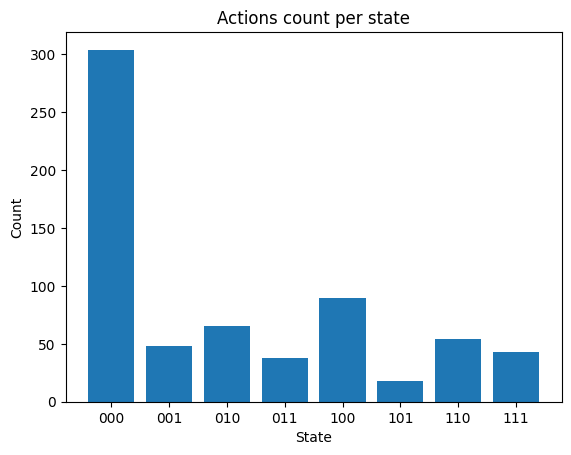

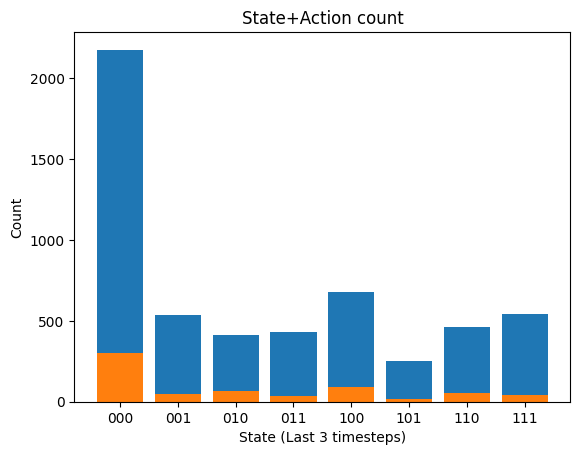

In [12]:
def plot_action_breakdown(states, actions,timestep=None):
    actions_by_state = np.zeros(n_states)
    state_counts = np.zeros(n_states)
    for i in range(n): # for each beneficary
        for j in range(L): # for each timestep
            if timestep == None:
                actions_by_state[int(states[0,0,j,i])] += actions[0,0,j,i]
                state_counts[int(states[0,0,j,i])] += 1
            else:
                if j ==timestep:
                    actions_by_state[int(states[0,0,j,i])] += actions[0,0,j,i]
                    state_counts[int(states[0,0,j,i])] += 1
    plt.xlabel('State')
    plt.ylabel('Count')
    plt.title('Actions count per state')

    plt.bar(['000','001','010','011','100','101','110','111'], actions_by_state)
    plt.show()

    plt.bar(['000','001','010','011','100','101','110','111'], state_counts)
    plt.bar(['000','001','010','011','100','101','110','111'], actions_by_state)
    plt.xlabel('State (Last 3 timesteps)')
    plt.ylabel('Count')
    plt.title('State+Action count')
    # Show the plot
    plt.show()

plot_action_breakdown(state_traj, action_traj)

In [13]:
# Applying aggregate command to trajectories
# In this file, our command is "Move 99% of calls from {111,101,110,011,001} to {000,100,010}"

# Percentage of calls to switch

edited_action_traj_listenership = np.copy(action_traj)
edited_state_traj_listenership = np.copy(state_traj)

uncalled_low_listeners_by_timestep={}
called_high_listeners_by_timestep={}

def get_switched_listeners(states,actions,h):
    uncalled_low_listeners = set()
    called_high_listeners = set()
    for i in range(n): # for each beneficary
        if actions[0,0,h,i] == 1 and (states[0,0,h,i] in {7,6,5,3,1}):
            called_high_listeners.add(i)
        if actions[0,0,h,i] == 0 and (states[0,0,h,i] in {2,4}):
            uncalled_low_listeners.add(i)
    return(uncalled_low_listeners,called_high_listeners)

confidence = .99

for h in range(1,L):
    uncalled_low_listeners,called_high_listeners = get_switched_listeners(edited_state_traj_listenership,edited_action_traj_listenership,h)
    total = len(uncalled_low_listeners)
    interventions_available = len(called_high_listeners)
    probability_switching = min(float(interventions_available)/total,1)
    for arm in range(n):
        if edited_action_traj_listenership[0,0,h,arm] == 0 and arm in uncalled_low_listeners and called_high_listeners != set():
            if np.random.random()<probability_switching:
                edited_action_traj_listenership[0,0,h,arm] = 1
                temp_index = called_high_listeners.pop()
                edited_action_traj_listenership[0,0,h,temp_index] = 0

In [14]:
def get_action_breakdown(states,actions,timestep=None):
    actions_by_state = np.zeros(n_states)
    for i in range(n): # for each beneficary
        for j in range(L): # for each timestep
            if timestep == None:
                actions_by_state[int(states[0,0,j,i])] += actions[0,0,j,i]
            else:
                if j ==timestep:
                    actions_by_state[int(states[0,0,j,i])] += actions[0,0,j,i]
    return actions_by_state

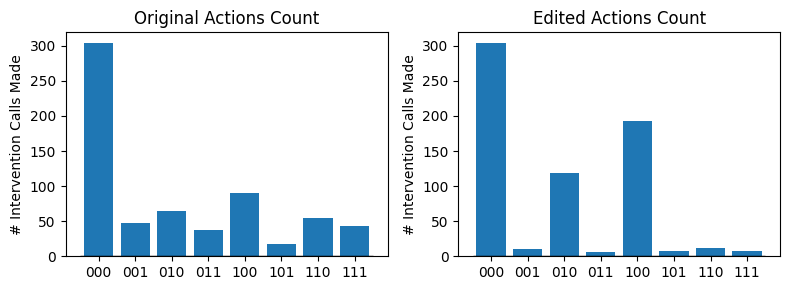

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3),sharey=True)
axs[0].set_title('Original Actions Count')
axs[0].set_ylabel('# Intervention Calls Made')
axs[0].bar(['000','001','010','011','100','101','110','111'], get_action_breakdown(state_traj, action_traj))

axs[1].bar(['000','001','010','011','100','101','110','111'], get_action_breakdown(edited_state_traj_listenership,edited_action_traj_listenership))
axs[1].set_title('Edited Actions Count')
axs[1].set_ylabel('# Intervention Calls Made')

axs[1].hlines(0, -0.5, 7.5, colors='black', linewidth=1)
axs[0].hlines(0, -0.5, 7.5, colors='black', linewidth=1)
axs[1].yaxis.set_tick_params(labelbottom=True)


plt.tight_layout()
plt.show()

In [111]:
# WHIRL - RUN IRL WITH NEW TRAJECTORIES
epochs = 30
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
uniform = True
if uniform:
    rewards = np.zeros((1,n_states))
    reward_param_edited = tf.Variable(rewards,dtype=float)
else:
    rewards = np.zeros((n, n_states))
    reward_param_edited = tf.Variable(rewards,dtype=float)
for epoch in range(epochs):
    print('EPOCH: {e}'.format(e=epoch))
    print('REWARD: {r}'.format(r=reward_param_edited))
    with tf.GradientTape() as tape:
        if uniform:
            reward_param_edited_n_benef = tf.repeat(reward_param_edited, n, axis=0)
            w = newWhittleIndex(tf.constant(transition_probabilities,dtype=tf.float32), reward_param_edited_n_benef)
        else:
            w = newWhittleIndex(tf.constant(transition_probabilities,dtype=tf.float32), reward_param_edited)
        w = tf.reshape(w, (n, n_states))
        performance, _, _, _,_ = eval_policy(state_record=edited_state_traj_listenership, action_record=edited_action_traj_listenership, w=w, w_opt=w_opt, H=L, K=K,
                                                  gamma=gamma,
                                                 target_policy_name='soft-whittle', beh_policy_name='soft-whittle',
                                                 transition_probabilities=transition_probabilities, epsilon=0.1, reward_estimate=reward_param_edited_n_benef if uniform else reward_param_edited, rewards_true=reward_opt)
        print("PERFORMANCE: {p}".format(p=performance))
    grad = tape.gradient(performance, reward_param_edited)
    print('GRAD: {g}'.format(g=grad))
    optimizer.apply_gradients(zip([grad], [reward_param_edited]))

print(reward_param_edited)
df = pd.DataFrame(reward_param_edited.numpy())
# df.to_excel('state_rewards.xlsx')

EPOCH: 0
REWARD: <tf.Variable 'Variable:0' shape=(1, 8) dtype=float32, numpy=array([[0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>
PERFORMANCE: 2721.19580078125
GRAD: [[  881.16406  -260.69724  -605.37225  -573.30554  -227.75679  -915.07477
   -525.3958  -3147.2212 ]]
EPOCH: 1
REWARD: <tf.Variable 'Variable:0' shape=(1, 8) dtype=float32, numpy=
array([[-0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01]],
      dtype=float32)>
PERFORMANCE: 2732.417724609375
GRAD: [[ 493.0899   220.50209 -365.16507  269.36612  204.79668 -315.75363
   234.18903 2543.2527 ]]
EPOCH: 2
REWARD: <tf.Variable 'Variable:0' shape=(1, 8) dtype=float32, numpy=
array([[-0.01948182,  0.01030794,  0.01958175,  0.01289826,  0.01000448,
         0.01876208,  0.01308878,  0.01053209]], dtype=float32)>
PERFORMANCE: 2724.6279296875
GRAD: [[ 347.30533  235.48271 -331.03314  237.43523  217.76083 -321.51617
   207.14339 2685.0225 ]]
EPOCH: 3
REWARD: <tf.Variable 'Variable:0' shape=(1, 8) dtype=float32, numpy=
array([

PERFORMANCE: 2596.584228515625
GRAD: [[ 289.4742    162.39279  -248.35207   381.24887   145.57262   -31.119677
   343.95453  2693.516   ]]
EPOCH: 24
REWARD: <tf.Variable 'Variable:0' shape=(1, 8) dtype=float32, numpy=
array([[ 0.01134771, -0.02467125,  0.13051102,  0.05541113, -0.02382467,
         0.19218312,  0.06469999, -0.01303117]], dtype=float32)>
PERFORMANCE: 2597.096435546875
GRAD: [[ 3.6446579e+02  1.9973267e+02 -1.7694954e+02  3.7859109e+02
   1.7772375e+02 -8.2704067e-01  3.3090424e+02  3.3836311e+03]]
EPOCH: 25
REWARD: <tf.Variable 'Variable:0' shape=(1, 8) dtype=float32, numpy=
array([[ 0.01216964, -0.02594073,  0.13593355,  0.05595544, -0.02509211,
         0.19828932,  0.06547625, -0.01381784]], dtype=float32)>
PERFORMANCE: 2593.91796875
GRAD: [[ 314.80396    171.3555    -167.62022    337.518      152.66246
    -6.5665016  293.67514   2945.756    ]]
EPOCH: 26
REWARD: <tf.Variable 'Variable:0' shape=(1, 8) dtype=float32, numpy=
array([[ 0.01226967, -0.02782922,  0.1414214

In [114]:
df_original = pd.read_excel('state_rewards.xlsx')
df_reward_param = df_original.values[:,1:]
df_reward_param = np.repeat(df_reward_param, n, axis=0)

# Get whittle index with new rewards so we can generate hypothetical trajectories for next 10 timesteps
w = newWhittleIndex(tf.constant(transition_probabilities,dtype=tf.float32), tf.Variable(df_reward_param, dtype=tf.float32))

['8_state_edited_uniform_rewards_2023-07-17 17:29:32.475178.xlsx', 'real_world_rewards_2023-07-06 14:49:21.159364.xlsx', 'bug_fix_transition_probabilities_8_state_real_world_data_removed_benefs_2023-08-06 01:50:08.005295.xlsx', '4_state_edited_uniform_rewards_2023-07-14 13:34:13.228995.xlsx', 'fast_listenership_metrics_computation.py', 'ArmmanIRL8state.ipynb', 'aaai_22_info.yml', 'nicetransitions_edits_epochs=30_edited_rewards_2023-07-30 12:17:34.590460.xlsx', '4_state_edited_rewards_2023-07-14 13:28:22.877465.xlsx', '8_state_edited_uniform_rewards_2023-07-18 14:25:40.503036.xlsx', 'Untitled1.ipynb', 'distribution_edits_8_state_edited_rewards_2023-07-28 18:32:40.951179.xlsx', 'real_world_rewards.xlsx', 'distribution_edits_8_state_edited_rewards_2023-07-27 15:38:25.647464.xlsx', '.DS_Store', 'edited_whittle_2023-07-13 13:50:04.463085.xlsx', 'CONFIG.py', 'edited_rewards_2023-07-11 14:54:55.791655.xlsx', 'Clean_Risk_Score_Experiments copy.ipynb', 'pilot_features.pkl', 'clean_epochs=50_edi

In [122]:
# Generate hypothetical trajectories using the WHIRL rewards
gamma=0.99
num_traj = 40
L=10
edited_state_traj_multiple = np.zeros((num_traj,1,L+1,n))
edited_action_traj_multiple = np.zeros((num_traj,1,L+1,n))
w = np.reshape(w,(n,transition_probabilities.shape[1]))
for i in range(num_traj):

    _, _, state_record_edited, action_record_edited, _ = getSimulatedTrajectories(
                                                                    n_benefs=n, T=L+1, K=K, n_trials=1, gamma=gamma,
                                                                    T_data=transition_probabilities, R_data=df_reward_param,
                                                                    w=w, replace=False, policies=[3], fast=True
                                                                    )
    
    edited_state_traj_multiple[i,0,:,:] = state_record_edited
    edited_action_traj_multiple[i,0,:,:] = action_record_edited
    

In [123]:
# Generate hypothetical trajectories using the original rewards
gamma=0.99
state_traj_multiple = np.zeros((num_traj,1,L+1,n))
action_traj_multiple = np.zeros((num_traj,1,L+1,n))
for i in range(num_traj):
    _, _, state_record_original, action_record_original, _ = getSimulatedTrajectories(
                                                                    n_benefs=n, T=L+1, K=K, n_trials=1, gamma=gamma,
                                                                    T_data=transition_probabilities, R_data=reward_opt.numpy(),
                                                                    w=w_opt, replace=False, policies=[3], fast=True
                                                                    )
    state_traj_multiple[i,0,:,:] = state_record_original
    action_traj_multiple[i,0,:,:] = action_record_original


2023-08-06 12:19:24,953 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:24,954 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:24,959 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:24,963 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:24,968 - INFO - update - Using categorical units to plo

2023-08-06 12:19:25,072 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,086 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,087 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,087 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,088 - INFO - update - Using categorical units to plo

2023-08-06 12:19:25,148 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,148 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,149 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,150 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,150 - INFO - update - Using categorical units to plo

760.0
760.0


2023-08-06 12:19:25,157 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,158 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,159 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,159 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,159 - INFO - update - Using categorical units to plo

2023-08-06 12:19:25,195 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,196 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,196 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,197 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,200 - INFO - update - Using categorical units to plo

2023-08-06 12:19:25,242 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,243 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,243 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,244 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,244 - INFO - update - Using categorical units to plo

2023-08-06 12:19:25,325 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,325 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,326 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,327 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,337 - INFO - update - Using categorical units to plo

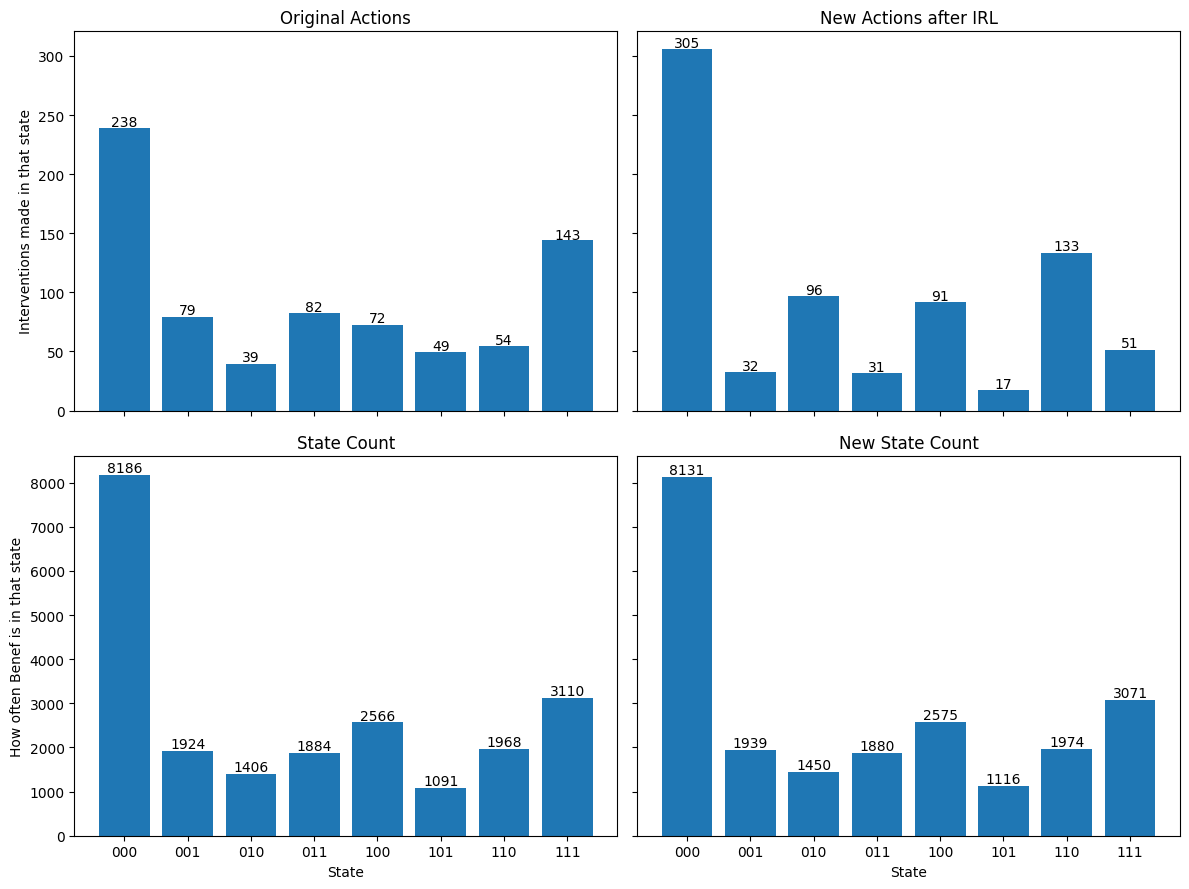

In [124]:
# Count original and edited interventions over states
edited_actions_summary_state = np.zeros(n_states)
edited_listening_summary_state = np.zeros(n_states)
actions_summary_state = np.zeros(n_states)
listening_summary_state = np.zeros(n_states)
for traj in range(num_traj):
    for i in range(n): # for each beneficary
        for h in range(L): # for each timestep
            edited_actions_summary_state[int(edited_state_traj_multiple[traj,0,h,i])] += edited_action_traj_multiple[traj,0,h,i]
            edited_listening_summary_state[int(edited_state_traj_multiple[traj,0,h,i])] += 1
            actions_summary_state[int(state_traj_multiple[traj,0,h,i])] += action_traj_multiple[traj,0,h,i]
            listening_summary_state[int(state_traj_multiple[traj,0,h,i])] += 1
x = ['000','001','010','011','100','101','110','111']
edited_actions_summary_state = edited_actions_summary_state/num_traj
edited_listening_summary_state = edited_listening_summary_state/num_traj
actions_summary_state = actions_summary_state/num_traj
listening_summary_state = listening_summary_state/num_traj

print(np.sum(edited_actions_summary_state))
print(np.sum(actions_summary_state))

fig, axs = plt.subplots(2, 2, figsize=(12, 9),sharex=True, sharey='row')

# Plot the bar charts in each subplot
axs[0, 0].bar(x, actions_summary_state)
axs[0, 0].set_title('Original Actions')
axs[0, 0].set_ylabel('Interventions made in that state')
for state, val in zip(x, actions_summary_state):
    axs[0, 0].text(state, int(val), str(int(val)), ha='center', va='bottom')

axs[0, 1].bar(x, edited_actions_summary_state)
axs[0, 1].set_title('New Actions after IRL')
for state, val in zip(x, edited_actions_summary_state):
    axs[0, 1].text(state, int(val), str(int(val)), ha='center', va='bottom')

axs[1, 0].bar(x, listening_summary_state)
axs[1, 0].set_title('State Count')
axs[1, 0].set_ylabel('How often Benef is in that state')
axs[1, 0].set_xlabel('State')
for state, val in zip(x, listening_summary_state):
    axs[1, 0].text(state, int(val), str(int(val)), ha='center', va='bottom')
axs[1, 1].set_xlabel('State')


axs[1, 1].bar(x, edited_listening_summary_state)
axs[1, 1].set_title('New State Count')
for state, val in zip(x, edited_listening_summary_state):
    axs[1, 1].text(state, int(val), str(int(val)), ha='center', va='bottom')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

2023-08-06 12:19:25,564 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,565 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,569 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,569 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


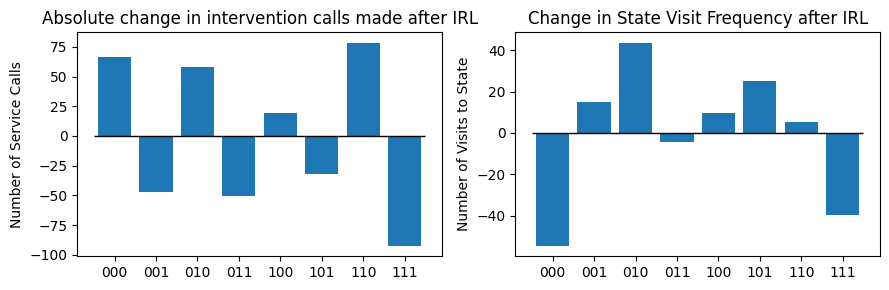

In [126]:
# Plot absolute change

edited_actions_summary_risk_abs = (edited_actions_summary_state - actions_summary_state)
edited_listening_summary_risk_abs = (edited_listening_summary_state - listening_summary_state)

fig, axs = plt.subplots(1, 2, figsize=(9, 3))
axs[0].set_title('Absolute change in intervention calls made after IRL')
axs[0].set_ylabel('Number of Service Calls')
axs[0].bar(x, edited_actions_summary_risk_abs)

axs[1].bar(x, edited_listening_summary_risk_abs)
axs[1].set_title('Change in State Visit Frequency after IRL')
axs[1].set_ylabel('Number of Visits to State')

axs[1].hlines(0, -0.5, len(x) - 0.5, colors='black', linewidth=1)
axs[0].hlines(0, -0.5, len(x) - 0.5, colors='black', linewidth=1)

plt.tight_layout()
plt.show()